Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.64MB/s]

Training samples: 12000
Test samples: 2000
Model parameters: 454,922

Training...


Epoch 1/5: Train Loss: 0.7757, Train Acc: 75.35%, Test Acc: 92.60%
Epoch 2/5: Train Loss: 0.2226, Train Acc: 93.34%, Test Acc: 95.95%
Epoch 3/5: Train Loss: 0.1449, Train Acc: 95.64%, Test Acc: 96.65%
Epoch 4/5: Train Loss: 0.1197, Train Acc: 96.45%, Test Acc: 97.85%
Epoch 5/5: Train Loss: 0.0926, Train Acc: 97.33%, Test Acc: 97.45%


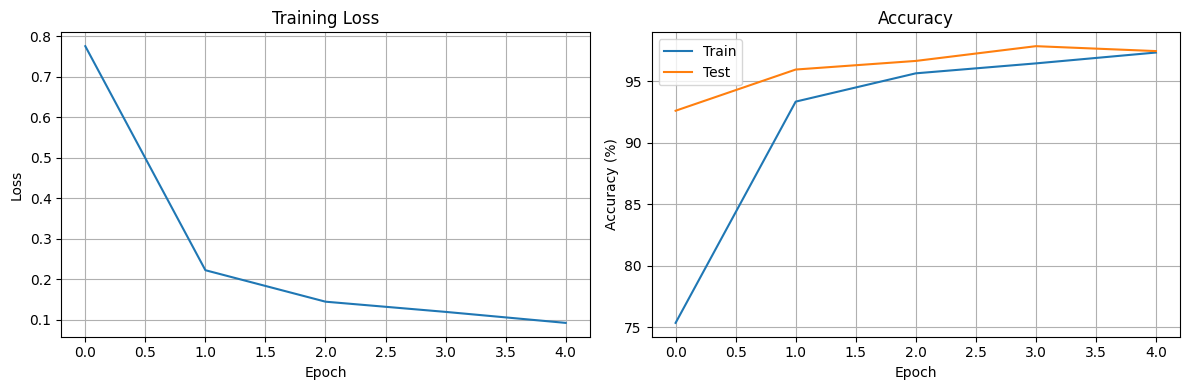

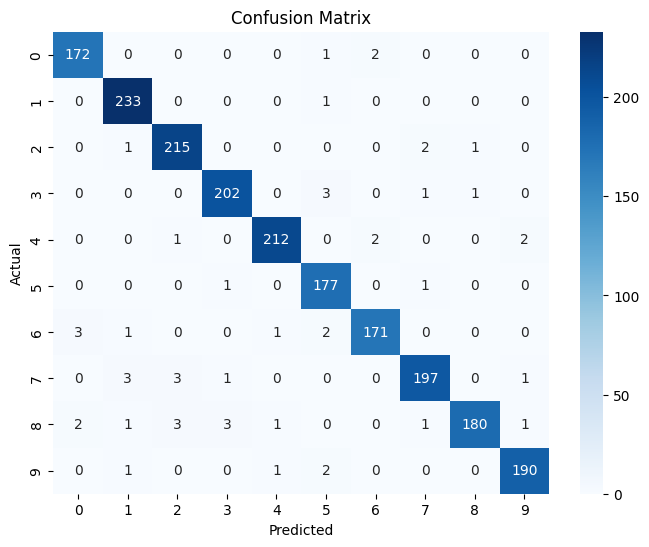

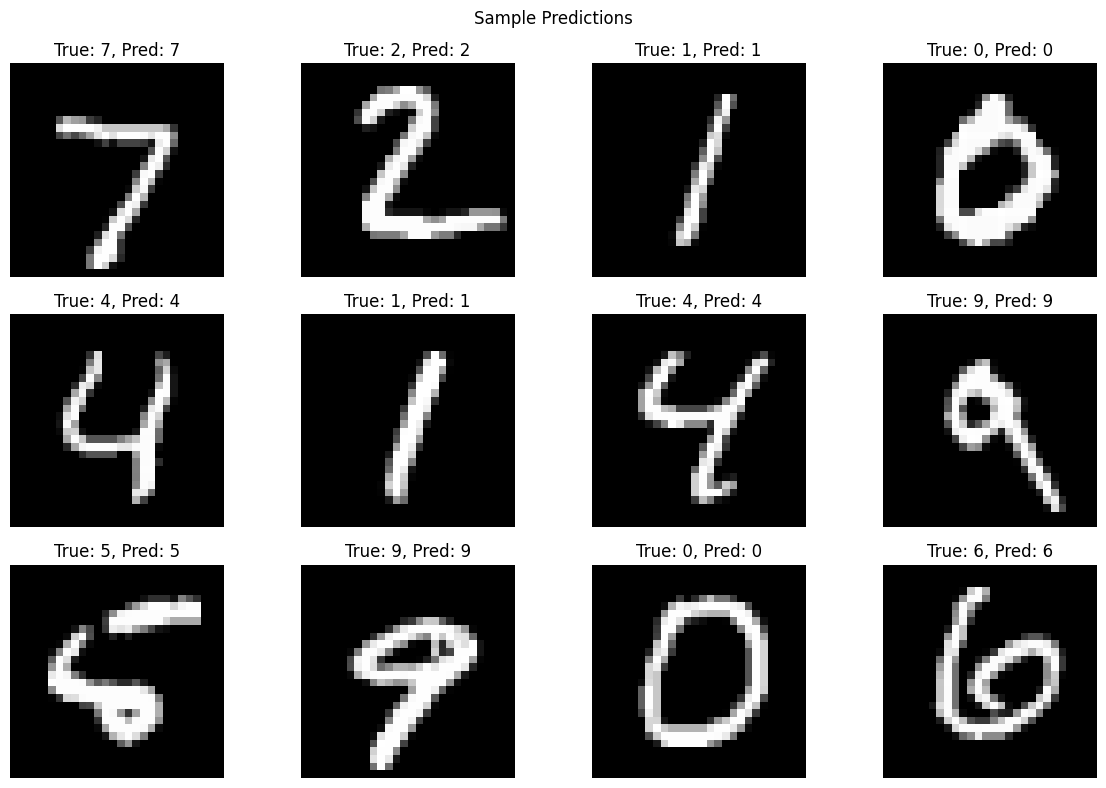


Final Test Accuracy: 97.45%
Optimized training complete!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# OPTIMIZED DATA LOADING
# =============================================================================

# Simplified transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = MNIST('./data', train=True, download=True, transform=transform)
test_dataset = MNIST('./data', train=False, download=True, transform=transform)

# REDUCE DATASET SIZE for faster training
train_subset = Subset(train_dataset, range(0, 12000))  # Only 12k samples instead of 60k
test_subset = Subset(test_dataset, range(0, 2000))     # Only 2k samples instead of 10k

# Increased batch size for efficiency
BATCH_SIZE = 256  # Increased from 128
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_subset)}")
print(f"Test samples: {len(test_subset)}")

# =============================================================================
# SIMPLIFIED MODEL
# =============================================================================

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Simplified architecture - fewer layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Removed third conv layer for speed
        # self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        # self.pool3 = nn.MaxPool2d(2, 2)

        # After 2 pooling layers: 28->14->7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Reduced from 100 to 128
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

# Optimized training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# =============================================================================
# FAST TRAINING
# =============================================================================

num_epochs = 5  # Reduced from 10

train_losses = []
train_accuracies = []
test_accuracies = []

print("\nTraining...")

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Testing
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()

    test_acc = 100. * test_correct / test_total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, '
          f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

# =============================================================================
# RESULTS AND VISUALIZATION
# =============================================================================

# Training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get predictions for confusion matrix
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.numpy())

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_targets, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Sample predictions
plt.figure(figsize=(12, 8))
data_iter = iter(test_loader)
images, labels = next(data_iter)

with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = images[i].squeeze() * 0.3081 + 0.1307  # Denormalize
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
    plt.axis('off')

plt.suptitle('Sample Predictions')
plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.2f}%")
print("Optimized training complete!")